In [ ]:
import torch
import numpy as np
import torch.nn as nn


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)

# https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/11
model.classifier._modules['6'] = nn.Linear(4096, 5)
model.eval()

Using cache found in /home/liana_e_koleva/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
def remove_suffix(input_string, suffix):
    if suffix and input_string.endswith(suffix):
        return input_string[:-len(suffix)]
    return input_string


In [ ]:
def create_labels(path):
    labels = dict()
    with open(path + "Metadata.csv", "r") as f:
        reader = csv.reader(f, delimiter="\t")
        for i, line in enumerate(reader):
            line = line[0].split(',') # split string into categories
            line[1] = line[1].lstrip() # clear whitespace
            labels[line[0]] = line[1]
    return labels

In [ ]:
from collections import defaultdict
from PIL import Image
import csv
import glob
import os 
import shutil
from custom_dataloader import CustomDataset, CLASSES


labels_rpi = create_labels("Plant_Phenotyping_Datasets/Plant/Ara2013-RPi/")
labels_canon = create_labels("Plant_Phenotyping_Datasets/Plant/Ara2013-Canon/")
# with open(path_rpi + "Metadata.csv", "r") as f:
#     reader = csv.reader(f, delimiter="\t")
#     for i, line in enumerate(reader):
#         line = line[0].split(',') # split string into categories
#         line[1] = line[1].lstrip() # clear whitespace
#         labels[line[0]] = line[1]

#############################################################################
# SPLIT IMAGES INTO DIRECTORIES BASED ON CLASS
#############################################################################
# Metadata.csv contains labels with keys ara2013_plant000 to ara2013_plant165
# labels = dict()
# with open("Metadata.csv", "r") as f:
#     reader = csv.reader(f, delimiter="\t")
#     for i, line in enumerate(reader):
#         line = line[0].split(',') # split string into categories
#         line[1] = line[1].lstrip() # clear whitespace
#         if line[1] not in labels:
#             labels[line[1]] = [line[0]]
#         else:   
#             labels[line[1]].append(line[0])
# print(labels)   

# for label in labels:
#     try:
#         os.mkdir(label)
#     except FileExistsError:
#         print("already exists")
        
#     for pngname in labels[label]:
#         pngfile = pngname + "_rgb.png"
#         shutil.copy(pngfile, label)   


In [ ]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

# def train_classifier(train_loader, classifier, criterion, optimizer):
#     classifier.train()
#     loss_ = 0.0
#     losses = []
#     for img_filename in glob.glob("*.png"):
#         # how to get image from img_filename?
#         image = img_filename.to(device)
        
#         # get label from name
#         name = remove_suffix(img_filename, "_rgb.png")
#         label = labels[name].to(device)
        
#         optimizer.zero_grad()
#         logits.classifier(images)
#         loss = criterion(logits, label)
#         loss.backward()
#         optimizer.step()
#         losses.append(loss)
        
#     return torch.stack(losses).mean().item()

In [ ]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True, print_total=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,5))
        y_score = np.zeros((0,5))
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss.item())
        aps = []
        # ignore first class which is background
        for i in range(1, y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(CLASSES[i], ap))
            aps.append(ap)
        
        mAP = np.mean(aps)
        test_loss = np.mean(losses)
        if print_total:
            print('mAP: {0:.4f}'.format(mAP))
            print('Avg loss: {}'.format(test_loss))
        
    return mAP, test_loss, aps

In [ ]:
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_mAP(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("mAP Plot")
    plt.ylabel("mAP")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()   

In [ ]:
def train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, test_frequency=5):
    train_losses = []
    train_mAPs = []
    val_losses = []
    val_mAPs = []

    for epoch in range(1,num_epochs+1):
        print("Starting epoch number " + str(epoch))
        train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
        train_losses.append(train_loss)
        print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
        if(epoch%test_frequency==0 or epoch==1):
            mAP_train, _, _ = test_classifier(train_loader, classifier, criterion, False, False)
            train_mAPs.append(mAP_train)
            mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
            print('Evaluating classifier')
            print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
            val_losses.append(val_loss)
            val_mAPs.append(mAP_val)
    
    return classifier, train_losses, val_losses, train_mAPs, val_mAPs

In [ ]:
import torchvision.transforms as transforms
from torchvision.transforms.transforms import RandomResizedCrop
from torch.utils.data import random_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225]) # is this custom to the mp3 data? 

# you should use the torchvision.transforms module to try adding 
# random resized crops and horizontal flips of the input data

# check transforms.RandomResizedCrop and transforms.RandomHorizontalFlip 

# feel free to apply more transforms for data augmentation 
# which can lead to better performance

train_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.RandomResizedCrop(227), # suggested add
            transforms.RandomHorizontalFlip(), # suggested add
            # transforms.RandomRotation(180), # self add
            transforms.ToTensor(),
            normalize
        ])

test_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.RandomResizedCrop(227), # suggested add
            transforms.RandomHorizontalFlip(), # suggested add
            # transforms.RandomRotation(180), # self add
            transforms.ToTensor(),
            normalize,
        ])

trainval = CustomDataset("Plant_Phenotyping_Datasets/Plant/Ara2013-RPi/", labels_rpi)
ds_train, ds_val = random_split(trainval, [140, 25])
ds_test = CustomDataset("Plant_Phenotyping_Datasets/Plant/Ara2013-Canon/", labels_canon)

# ds_train = VocDataset('VOCdevkit_2007/VOC2007/','train',train_transform)
# ds_val = VocDataset('VOCdevkit_2007/VOC2007/','val',test_transform)
# ds_test = VocDataset('VOCdevkit_2007/VOC2007test/','test', test_transform)

In [ ]:
num_epochs = 50
test_frequency = 5
batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               num_workers=1)

val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               num_workers=1)

test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=batch_size, 
                                               shuffle=False,
                                               num_workers=1)

In [ ]:
classifier = model.to(device)
from sklearn.metrics import average_precision_score

# classifier.load_state_dict(torch.load('voc_my_best_classifier.pth'))
import torch.nn as nn

criterion = nn.MultiLabelSoftMarginLoss()

# instead of plain SGD, you may want to add a learning rate schedule, add momentum, 
# or use one of the other optimizers you have learned about like Adam
# check the torch.optim package for other optimizers
# optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)

classifier, train_losses, val_losses, train_mAPs, val_mAPs = train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, test_frequency)


Starting epoch number 1
Loss for Training on Epoch 1 is 0.5786656141281128
-------  Class: ctr              AP:   1.0000  -------
-------  Class: Col-0            AP:   0.4206  -------
-------  Class: pgm              AP:   0.4454  -------
-------  Class: adh1             AP:   0.1488  -------
mAP: 0.5037
Avg loss: 0.5236824750900269
Evaluating classifier
Mean Precision Score for Testing on Epoch 1 is 0.5036927784187557
Starting epoch number 2
Loss for Training on Epoch 2 is 0.49314042925834656
Starting epoch number 3
Loss for Training on Epoch 3 is 0.47220033407211304
Starting epoch number 4
Loss for Training on Epoch 4 is 0.44112151861190796
Starting epoch number 5
Loss for Training on Epoch 5 is 0.39543241262435913
-------  Class: ctr              AP:   0.9500  -------
-------  Class: Col-0            AP:   0.2310  -------
-------  Class: pgm              AP:   0.5063  -------
-------  Class: adh1             AP:   0.7708  -------
mAP: 0.6145
Avg loss: 0.34701141715049744
Evaluating

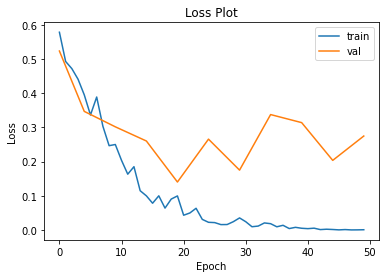

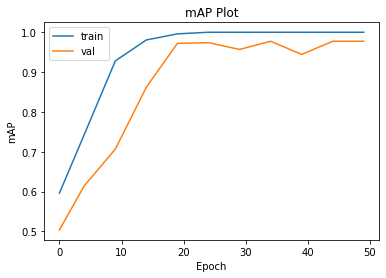

In [ ]:
import matplotlib.pyplot as plt
plot_losses(train_losses, val_losses, test_frequency, num_epochs)
plot_mAP(train_mAPs, val_mAPs, test_frequency, num_epochs)

In [ ]:
mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)
print(mAP_test)

-------  Class: ctr              AP:   1.0000  -------
-------  Class: Col-0            AP:   0.9962  -------
-------  Class: pgm              AP:   0.9364  -------
-------  Class: adh1             AP:   1.0000  -------
mAP: 0.9832
Avg loss: 0.21127100785573324
0.9831657978048484


NameError: name 'output_submission_csv' is not defined